# License

***

J. Patrick Hall (phall@h2o.ai), and the H2O.ai team. 

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:
The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

# Imports and Setup

***

#### Imports

In [1]:
# system utility packages
import os
import pickle
import re
import subprocess

# for in-notebook display of DT surrogate image
from IPython.display import Image
from IPython.display import display

# standard analytical/modeling packages
import h2o
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb

# specialized analytical packages
from data_maker_and_getter import DataMakerAndGetter              # custom utility file, used to find percentiles here
from h2o.estimators.random_forest import H2ORandomForestEstimator # to train single-tree for DT surrogate
from h2o.backend import H2OLocalServer                            # to find path to h2o.jar to make DT surrogate image
import shap                                                       # needed to make shap summary plot

# global settings
pd.options.display.max_columns = 999 # enable display of all columns in notebook
np.random.seed(12345) # for reproducibility of the many things that call numpy

# display standard graphics in-notebook
%matplotlib inline

#### Start H2O for surrogate decision tree

In [2]:
h2o.init(max_mem_size='1G') # allocate reasonable memory
h2o.remove_all()            # remove any data that may have been on the h2o cluster

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_112"; Java(TM) SE Runtime Environment (build 1.8.0_112-b16); Java HotSpot(TM) 64-Bit Server VM (build 25.112-b16, mixed mode)
  Starting server from /Users/phall/anaconda/lib/python3.5/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/tc/0ss1l73113j3wdyjsxmy1j2r0000gn/T/tmppv2zl9w4
  JVM stdout: /var/folders/tc/0ss1l73113j3wdyjsxmy1j2r0000gn/T/tmppv2zl9w4/h2o_phall_started_from_python.out
  JVM stderr: /var/folders/tc/0ss1l73113j3wdyjsxmy1j2r0000gn/T/tmppv2zl9w4/h2o_phall_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,01 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.18.0.11
H2O cluster version age:,2 months and 20 days
H2O cluster name:,H2O_from_python_phall_qr25id
H2O cluster total nodes:,1
H2O cluster free memory:,910 Mb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


#  Explore and prepare diabetes data

***

#### Import data and examine Kaggle diabetes data set
The original data is available here: https://www.kaggle.com/brandao/diabetes. The data set contains demographic and medical information about many patients. It will be used to create a white-box classifier for predicting who will be readmitted to a hospital within 30 days of discharge. This notebooks attempts to showcase the use of a complex, but transparent, nonlinear classifier as alternative to more traditional linear model approaches.

In [3]:
# import CSV file
# set numeric categoricals to objects in train and test

train = pd.read_csv('data/diabetes_train.csv')
train['discharge_disposition_id'] = train['discharge_disposition_id'].astype('object')
train['admission_type_id'] = train['admission_type_id'].astype('object')
train['admission_source_id'] = train['admission_source_id'].astype('object')

test = pd.read_csv('data/diabetes_test.csv')
test['discharge_disposition_id'] = test['discharge_disposition_id'].astype('object')
test['admission_type_id'] = test['admission_type_id'].astype('object')
test['admission_source_id'] = test['admission_source_id'].astype('object')

#### Examine data to assess quality issues
`XGBoost` handles missing values nicely. But a few other problems can be seen:
* High cardinality categorical variables 
* Constant variables 
* Character variables (`XGBoost` handles character variables in a naive way)

In [4]:
train.head(n=10) # display first n= rows

,id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
2,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
3,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO
4,55842,84259809,Caucasian,Male,[60-70),?,3,1,2,4,?,?,70,1,21,0,0,0,414,411,V45,7,None,None,Steady,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO
5,12522,48330783,Caucasian,Female,[80-90),?,2,1,4,13,?,?,68,2,28,0,0,0,398,427,38,8,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO
6,15738,63555939,Caucasian,Female,[90-100),?,3,3,4,12,?,InternalMedicine,33,3,18,0,0,0,434,198,486,8,None,None,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO
7,36900,77391171,AfricanAmerican,Male,[60-70),?,2,1,4,7,?,?,62,0,11,0,0,0,157,288,197,7,None,None,No,No,No,No,No,No,No,Up,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,<30
8,40926,85504905,Caucasian,Female,[40-50),?,1,3,7,7,?,Family/GeneralPractice,60,0,15,0,1,0,428,250.43,250.6,8,None,None,Steady,Up,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Down,No,No,No,No,No,Ch,Yes,<30
9,42570,77586282,Caucasian,Male,[80-90),?,1,6,7,10,?,Family/GeneralPractice,55,1,31,0,0,0,428,411,427,8,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,NO


#### Examine high cardinality inputs
One obvious problem with the data is the high cardinality categorical variables:

* `discharge_disposition_id`
* `medical_specialty`
* `diag_1`
* `diag_2`
* `diag_3`

have the most levels and will be binned.

In [5]:
for col in train.select_dtypes(include=['object']):    # loop through categorical variables
    n_levels = len(train[col].unique())                # determine number of unique levels
    if n_levels > 20:                                  # if unique levels > 20, then print
        print(col + ' levels: ', train[col].unique())
        print()

discharge_disposition_id levels:  [25 1 3 6 11 5 2 4 10 7 14 8 18 13 12 22 17 23 9 16 20 15 24 28 19 27]

medical_specialty levels:  ['Pediatrics-Endocrinology' '?' 'InternalMedicine' 'Family/GeneralPractice'
 'Cardiology' 'Surgery-General' 'Orthopedics' 'Gastroenterology'
 'Nephrology' 'Orthopedics-Reconstructive'
 'Surgery-Cardiovascular/Thoracic' 'Pulmonology' 'Psychiatry'
 'Emergency/Trauma' 'Surgery-Neuro' 'Obsterics&Gynecology-GynecologicOnco'
 'ObstetricsandGynecology' 'Pediatrics' 'Otolaryngology'
 'Surgery-Colon&Rectal' 'Urology' 'Psychiatry-Child/Adolescent'
 'Endocrinology' 'Neurology' 'Anesthesiology-Pediatric'
 'Pediatrics-CriticalCare' 'Radiology' 'Pediatrics-Hematology-Oncology'
 'Psychology' 'Hematology/Oncology' 'Podiatry' 'Gynecology' 'Oncology'
 'Pediatrics-Neurology' 'Surgery-Plastic' 'Surgery-Thoracic'
 'Surgery-Pediatric' 'Pediatrics-EmergencyMedicine'
 'PhysicalMedicineandRehabilitation' 'Pediatrics-Pulmonology'
 'Anesthesiology' 'Ophthalmology' 'InfectiousDiseas

#### Utility function for simple binning of less common categorical levels
This function handles high cardinality categorial variables by binning all less common levels into an 'Other' bin. This is a simple, interpretable method of handling high cardinality categorical variables. Each of these levels will end up being it's own input variable into the readmission classifier. So it's important there are not too many levels and that the levels have a direct, transparent meaning.

In [6]:
def bin_less_common_levels(train, test, col_name, in_list):
    
    """ Places less common categorical levels into an 'Other' bin.
    
    :param train: Training set.
    :param test: Test set.
    :param col_name: Name of column in which to create 'Other' bin.
    :param in_list: List of levels NOT to be binned.
    
    """
    
    # if the level is not in in_list, set it to 'Other'
    train.loc[~train[col_name].isin(in_list), col_name] = 'Other' 
    test.loc[~test[col_name].isin(in_list), col_name] = 'Other'   

    # print summary of changes
    print('Train levels after binning:\n', train[col_name].value_counts())
    print()
    print('Test levels after binning:\n', test[col_name].value_counts())
    

#### Bin `discharge_disposition_id`

In [7]:
in_list = list(train['discharge_disposition_id'].value_counts()[:14].index) # first 14 levels contain reasonable amount of info
bin_less_common_levels(train, test, 'discharge_disposition_id', in_list)    # set all other levels to 'Other'

Train levels after binning:
 1        28733
3         6599
6         5414
18        2656
11        1329
2         1116
22        1076
5          741
25         606
4          475
7          307
Other      257
14         246
13         227
23         219
Name: discharge_disposition_id, dtype: int64

Test levels after binning:
 1        9985
3        2439
6        2126
22        398
2         344
11        313
13        136
14        119
7          95
5          93
4          62
23         49
Other      47
18          8
25          7
Name: discharge_disposition_id, dtype: int64


#### Bin `medical_specialty`

In [8]:
in_list = list(train['medical_specialty'].value_counts()[:10].index) # first 10 levels contain reasonable amount of info
bin_less_common_levels(train, test, 'medical_specialty', in_list)    # set all other levels to 'Other'

Train levels after binning:
 ?                             20893
InternalMedicine               8899
Other                          5162
Family/GeneralPractice         4370
Cardiology                     3037
Emergency/Trauma               2824
Surgery-General                1649
Orthopedics-Reconstructive      898
Nephrology                      883
Orthopedics                     839
Psychiatry                      547
Name: medical_specialty, dtype: int64

Test levels after binning:
 ?                             10841
Emergency/Trauma               1735
InternalMedicine               1013
Other                           974
Cardiology                      462
Family/GeneralPractice          407
Surgery-General                 404
Orthopedics                     234
Nephrology                       64
Psychiatry                       45
Orthopedics-Reconstructive       42
Name: medical_specialty, dtype: int64


#### Bin `diag_1`

In [9]:
in_list = list(train['diag_1'].value_counts()[:20].index) # first 20 levels contain reasonable amount of info
bin_less_common_levels(train, test, 'diag_1', in_list)    # set all other levels to 'Other'

Train levels after binning:
 Other    25298
414       3464
428       2924
786       2071
410       1992
486       1662
427       1256
715       1103
434       1103
780        974
682        936
996        909
276        895
38         799
491        791
250.8      709
599        689
584        677
V57        651
820        590
518        508
Name: diag_1, dtype: int64

Test levels after binning:
 Other    8061
414       993
428       849
410       557
427       536
786       527
715       480
486       477
491       411
434       337
38        335
682       332
584       319
780       315
599       289
996       287
276       281
250.8     269
518       240
820       195
V57       131
Name: diag_1, dtype: int64


#### Bin `diag_2`

In [10]:
in_list = list(train['diag_2'].value_counts()[:20].index) # first 20 levels contain reasonable amount of info
bin_less_common_levels(train, test, 'diag_2', in_list)    # set all other levels to 'Other'

Train levels after binning:
 Other     20558
250        3425
276        3399
428        3233
427        2564
401        2094
496        1681
599        1570
403        1373
411        1358
414        1248
250.02     1060
250.01      944
707         879
780         794
285         667
682         646
518         641
425         639
491         630
424         598
Name: diag_2, dtype: int64

Test levels after binning:
 Other     8346
250        966
276        961
428        750
427        643
401        607
599        555
414        503
285        350
518        311
707        302
411        285
496        283
250.02     255
491        217
682        210
425        199
780        171
403        164
424         88
250.01      55
Name: diag_2, dtype: int64


#### Bin `diag_3`

In [11]:
in_list = list(train['diag_3'].value_counts()[:20].index) # first 20 levels contain reasonable amount of info
bin_less_common_levels(train, test, 'diag_3', in_list)    # set all other levels to 'Other'

Train levels after binning:
 Other     20338
250        6212
401        4473
276        2516
428        2102
427        1906
414        1701
496        1336
403        1023
272        1019
?           985
599         927
585         725
V45         686
780         662
707         640
250.02      631
285         558
250.01      541
424         522
250.6       498
Name: diag_3, dtype: int64

Test levels after binning:
 Other     7415
250       1777
401       1331
276        868
414        612
428        603
427        545
585        412
272        388
403        347
599        319
496        270
285        228
250.02     220
780        207
707        191
V45        143
250.6      124
424        101
?          100
250.01      20
Name: diag_3, dtype: int64


#### Check binning results
Now all of the categorical variables in the data set have a reasonable number of unique levels for modeling.

In [12]:
for col in train.select_dtypes(include=['object']): # loop through categorical vars
    n_levels = len(train[col].unique())             # find number of unique levels
    print(col, n_levels)                            # print

race 6
gender 3
age 10
weight 9
admission_type_id 8
discharge_disposition_id 15
admission_source_id 14
payer_code 17
medical_specialty 11
diag_1 21
diag_2 21
diag_3 21
max_glu_serum 4
A1Cresult 4
metformin 4
repaglinide 4
nateglinide 4
chlorpropamide 4
glimepiride 4
acetohexamide 1
glipizide 4
glyburide 4
tolbutamide 2
pioglitazone 4
rosiglitazone 4
acarbose 4
miglitol 4
troglitazone 2
tolazamide 2
examide 1
citoglipton 1
insulin 4
glyburide-metformin 4
glipizide-metformin 2
glimepiride-pioglitazone 1
metformin-rosiglitazone 1
metformin-pioglitazone 1
change 2
diabetesMed 2
readmitted 2


#### Define target and variables to be dropped from the analysis
Different lists of variables are assigned to handle converting character variables into numeric dummy variables. It's pointless to encode constant variables and the categorical target variable, `readmit`, will be handled on it's own later.

In [13]:
# constant column
constants = ['acetohexamide', 'examide', 'citoglipton', 'citoglipton', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone']

y = 'readmitted' # modeling prediction target

# python sets allow for subtraction, lists do not
# used here to find the categorical variables that should be dummy-encoded for modeling
# convert back to a list for later use 
encodes = list(set(train.select_dtypes(include=['object']).columns) - set(constants + [y]))

#### Dummy-encode categorical variables into numeric variables
The built-in `Pandas` function `get_dummies()` creates new binary variables for each unique level in an original categorical variable. Each of these columns can be used directly in `XGBoost`.

In [14]:
# drop the original categorical variables
# then join the dummy-encoded versions of the same categorical variables back into the data

train = pd.concat([train.drop(encodes, axis=1),
                   pd.get_dummies(train[encodes])],
                   axis = 1)

test = pd.concat([test.drop(encodes, axis=1),
                  pd.get_dummies(test[encodes])],
                   axis = 1)

#### Ensure train and test have the same input variables after encoding
If a variable has different levels in the train and test sets this will result in different variables in the new, encoded train and test sets. This can cause problems with over-optimistic accuracy in training and errors when attempting to score unseen levels in the test set. 

In [15]:
# in case there were any categorical variable levels in test and not in train
# (or vice-versa)
# drop them

in_train_not_test = list(set(train.columns)-set(test.columns)) # set subtraction
train.drop(in_train_not_test, axis=1, inplace=True)

in_test_not_train = list(set(test.columns)-set(train.columns)) # set subtraction
test.drop(in_test_not_train, axis=1, inplace=True)

#### Ensure names are safe for `XGBoost`
`XGBoost` and `Pandas` have different variable name requirements. As a consequence of the dummy encoding proccess, some encoded variables were created with non-alphanumeric characters in their names.

In [16]:
for name in train.columns:
    
    # use python replace function to replace common '_?' suffix
    # use regex to catch everything else
    
    train.rename(columns={name: name.replace('_?', '_q')}, inplace=True)   
    train.rename(columns={name: re.sub('[^0-9a-zA-Z]+', '_', name)}, inplace=True)
    
    test.rename(columns={name: name.replace('_?', '_q')}, inplace=True)
    test.rename(columns={name: re.sub('[^0-9a-zA-Z]+', '_', name)}, inplace=True)
    

#### Check encodig results

In [17]:
print('All train and test columns match:', all(train.columns == test.columns)) # test all names match
print('Train set shape:', train.shape)                                         # test number of columns match
print('Test set shape:', test.shape)                                           # test number of columns match

All train and test columns match: True
Train set shape: (50001, 233)
Test set shape: (16221, 233)


#### Assign modeling roles
The constants list must be redefined after handling the names for `XGBoost`. The inputs to the classifier, `X`, are defined to be all of the original numeric variables and all of the new encoded variables that are not patient identifiers or constant.

In [18]:
# names of drops were changed in steps above, must redefine ('-' became '_')
constants = ['acetohexamide', 'examide', 'citoglipton', 'citoglipton', 'glimepiride_pioglitazone', 'metformin_rosiglitazone', 
             'metformin_pioglitazone'] 

# everything that is not constant, an identifier, or the modeling target will be a modeling input
X = [name for name in train.columns if name not in [y] + constants + ['id', 'patient_nbr']]

# print summary
print('y =', y)
print('X =', X)

y = readmitted
X = ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'glyburide_metformin_No', 'glyburide_metformin_Steady', 'discharge_disposition_id_1', 'discharge_disposition_id_2', 'discharge_disposition_id_3', 'discharge_disposition_id_4', 'discharge_disposition_id_5', 'discharge_disposition_id_6', 'discharge_disposition_id_7', 'discharge_disposition_id_11', 'discharge_disposition_id_13', 'discharge_disposition_id_14', 'discharge_disposition_id_18', 'discharge_disposition_id_22', 'discharge_disposition_id_23', 'discharge_disposition_id_25', 'discharge_disposition_id_Other', 'max_glu_serum_200', 'max_glu_serum_300', 'max_glu_serum_None', 'max_glu_serum_Norm', 'glipizide_Down', 'glipizide_No', 'glipizide_Steady', 'glipizide_Up', 'rosiglitazone_Down', 'rosiglitazone_No', 'rosiglitazone_Steady', 'rosiglitazone_Up', 'tolbutamide_No', 'tolbutamide_Steady', 'payer_code_q', 'paye

#### Ensure Pandas treats all input variables as numeric

In [19]:
# xgboost treats all columns as numeric - no matter what
# any values that can't be converted easily will be NaN - XGBoost does handle NaN elegantly
train[X] = train[X].apply(pd.to_numeric, errors='coerce', axis=1) 
test[X] = test[X].apply(pd.to_numeric, errors='coerce', axis=1)

#### Manually convert target variable to numeric

Using `get_dummies()` would have resulted in two perfectly negatively correlated copies of the target variable. Instead the target is manually transformed so that patient readmission results in higher numeric probabilities being generated by the classifier.

In [20]:
# convert target to numeric value
# readmit = NO -> 0
# readmit = YES -> 1
train.loc[train[y] == 'NO', y] = '0'
train.loc[train[y] != '0', y] = '1'
train[y] = train[y].apply(pd.to_numeric)

test.loc[test[y] == 'NO', y] = '0'
test.loc[test[y] != '0', y] = '1'
test[y] = test[y].apply(pd.to_numeric)

#### Investigate all data preprocessing for train set

In [21]:
train[X + [y]].head() # print only columns used in modeling

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,glyburide_metformin_No,glyburide_metformin_Steady,discharge_disposition_id_1,discharge_disposition_id_2,discharge_disposition_id_3,discharge_disposition_id_4,discharge_disposition_id_5,discharge_disposition_id_6,discharge_disposition_id_7,discharge_disposition_id_11,discharge_disposition_id_13,discharge_disposition_id_14,discharge_disposition_id_18,discharge_disposition_id_22,discharge_disposition_id_23,discharge_disposition_id_25,discharge_disposition_id_Other,max_glu_serum_200,max_glu_serum_300,max_glu_serum_None,max_glu_serum_Norm,glipizide_Down,glipizide_No,glipizide_Steady,glipizide_Up,rosiglitazone_Down,rosiglitazone_No,rosiglitazone_Steady,rosiglitazone_Up,tolbutamide_No,tolbutamide_Steady,payer_code_q,payer_code_BC,payer_code_CH,payer_code_CM,payer_code_CP,payer_code_DM,payer_code_HM,payer_code_MC,payer_code_MD,payer_code_MP,payer_code_OG,payer_code_OT,payer_code_PO,payer_code_SI,payer_code_SP,payer_code_UN,payer_code_WC,metformin_Down,metformin_No,metformin_Steady,metformin_Up,acarbose_No,acarbose_Steady,gender_Female,gender_Male,gender_Unknown_Invalid,race_q,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,A1Cresult_7,A1Cresult_8,A1Cresult_None,A1Cresult_Norm,diabetesMed_No,diabetesMed_Yes,chlorpropamide_No,chlorpropamide_Steady,medical_specialty_q,medical_specialty_Cardiology,medical_specialty_Emergency_Trauma,medical_specialty_Family_GeneralPractice,medical_specialty_InternalMedicine,medical_specialty_Nephrology,medical_specialty_Orthopedics,medical_specialty_Orthopedics_Reconstructive,medical_specialty_Other,medical_specialty_Psychiatry,medical_specialty_Surgery_General,diag_1_250_8,diag_1_276,diag_1_38,diag_1_410,diag_1_414,diag_1_427,diag_1_428,diag_1_434,diag_1_486,diag_1_491,diag_1_518,diag_1_584,diag_1_599,diag_1_682,diag_1_715,diag_1_780,diag_1_786,diag_1_820,diag_1_996,diag_1_Other,diag_1_V57,glipizide_metformin_No,pioglitazone_Down,pioglitazone_No,pioglitazone_Steady,pioglitazone_Up,glyburide_Down,glyburide_No,glyburide_Steady,glyburide_Up,nateglinide_Down,nateglinide_No,nateglinide_Steady,nateglinide_Up,weight_q,weight_0_25_,weight_100_125_,weight_125_150_,weight_150_175_,weight_175_200_,weight_25_50_,weight_50_75_,weight_75_100_,admission_source_id_1,admission_source_id_2,admission_source_id_3,admission_source_id_4,admission_source_id_5,admission_source_id_6,admission_source_id_7,admission_source_id_8,admission_source_id_9,admission_source_id_14,admission_source_id_17,admission_source_id_22,change_Ch,change_No,troglitazone_No,tolazamide_No,admission_type_id_1,admission_type_id_2,admission_type_id_3,admission_type_id_4,admission_type_id_5,admission_type_id_6,admission_type_id_7,admission_type_id_8,glimepiride_Down,glimepiride_No,glimepiride_Steady,glimepiride_Up,miglitol_Down,miglitol_No,miglitol_Steady,insulin_Down,insulin_No,insulin_Steady,insulin_Up,age_0_10_,age_10_20_,age_20_30_,age_30_40_,age_40_50_,age_50_60_,age_60_70_,age_70_80_,age_80_90_,age_90_100_,diag_3_250,diag_3_250_01,diag_3_250_02,diag_3_250_6,diag_3_272,diag_3_276,diag_3_285,diag_3_401,diag_3_403,diag_3_414,diag_3_424,diag_3_427,diag_3_428,diag_3_496,diag_3_585,diag_3_599,diag_3_707,diag_3_780,diag_3_q,diag_3_Other,diag_3_V45,repaglinide_Down,repaglinide_No,repaglinide_Steady,repaglinide_Up,diag_2_250,diag_2_250_01,diag_2_250_02,diag_2_276,diag_2_285,diag_2_401,diag_2_403,diag_2_411,diag_2_414,diag_2_424,diag_2_425,diag_2_427,diag_2_428,diag_2_491,diag_2_496,diag_2_518,diag_2_599,diag_2_682,diag_2_707,diag_2_780,diag_2_Other,readmitted
0,1,41,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0

#### Investigate all data preprocessing for test set 

In [22]:
test[X + [y]].head() # print only columns used in modeling

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,glyburide_metformin_No,glyburide_metformin_Steady,discharge_disposition_id_1,discharge_disposition_id_2,discharge_disposition_id_3,discharge_disposition_id_4,discharge_disposition_id_5,discharge_disposition_id_6,discharge_disposition_id_7,discharge_disposition_id_11,discharge_disposition_id_13,discharge_disposition_id_14,discharge_disposition_id_18,discharge_disposition_id_22,discharge_disposition_id_23,discharge_disposition_id_25,discharge_disposition_id_Other,max_glu_serum_200,max_glu_serum_300,max_glu_serum_None,max_glu_serum_Norm,glipizide_Down,glipizide_No,glipizide_Steady,glipizide_Up,rosiglitazone_Down,rosiglitazone_No,rosiglitazone_Steady,rosiglitazone_Up,tolbutamide_No,tolbutamide_Steady,payer_code_q,payer_code_BC,payer_code_CH,payer_code_CM,payer_code_CP,payer_code_DM,payer_code_HM,payer_code_MC,payer_code_MD,payer_code_MP,payer_code_OG,payer_code_OT,payer_code_PO,payer_code_SI,payer_code_SP,payer_code_UN,payer_code_WC,metformin_Down,metformin_No,metformin_Steady,metformin_Up,acarbose_No,acarbose_Steady,gender_Female,gender_Male,gender_Unknown_Invalid,race_q,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,A1Cresult_7,A1Cresult_8,A1Cresult_None,A1Cresult_Norm,diabetesMed_No,diabetesMed_Yes,chlorpropamide_No,chlorpropamide_Steady,medical_specialty_q,medical_specialty_Cardiology,medical_specialty_Emergency_Trauma,medical_specialty_Family_GeneralPractice,medical_specialty_InternalMedicine,medical_specialty_Nephrology,medical_specialty_Orthopedics,medical_specialty_Orthopedics_Reconstructive,medical_specialty_Other,medical_specialty_Psychiatry,medical_specialty_Surgery_General,diag_1_250_8,diag_1_276,diag_1_38,diag_1_410,diag_1_414,diag_1_427,diag_1_428,diag_1_434,diag_1_486,diag_1_491,diag_1_518,diag_1_584,diag_1_599,diag_1_682,diag_1_715,diag_1_780,diag_1_786,diag_1_820,diag_1_996,diag_1_Other,diag_1_V57,glipizide_metformin_No,pioglitazone_Down,pioglitazone_No,pioglitazone_Steady,pioglitazone_Up,glyburide_Down,glyburide_No,glyburide_Steady,glyburide_Up,nateglinide_Down,nateglinide_No,nateglinide_Steady,nateglinide_Up,weight_q,weight_0_25_,weight_100_125_,weight_125_150_,weight_150_175_,weight_175_200_,weight_25_50_,weight_50_75_,weight_75_100_,admission_source_id_1,admission_source_id_2,admission_source_id_3,admission_source_id_4,admission_source_id_5,admission_source_id_6,admission_source_id_7,admission_source_id_8,admission_source_id_9,admission_source_id_14,admission_source_id_17,admission_source_id_22,change_Ch,change_No,troglitazone_No,tolazamide_No,admission_type_id_1,admission_type_id_2,admission_type_id_3,admission_type_id_4,admission_type_id_5,admission_type_id_6,admission_type_id_7,admission_type_id_8,glimepiride_Down,glimepiride_No,glimepiride_Steady,glimepiride_Up,miglitol_Down,miglitol_No,miglitol_Steady,insulin_Down,insulin_No,insulin_Steady,insulin_Up,age_0_10_,age_10_20_,age_20_30_,age_30_40_,age_40_50_,age_50_60_,age_60_70_,age_70_80_,age_80_90_,age_90_100_,diag_3_250,diag_3_250_01,diag_3_250_02,diag_3_250_6,diag_3_272,diag_3_276,diag_3_285,diag_3_401,diag_3_403,diag_3_414,diag_3_424,diag_3_427,diag_3_428,diag_3_496,diag_3_585,diag_3_599,diag_3_707,diag_3_780,diag_3_q,diag_3_Other,diag_3_V45,repaglinide_Down,repaglinide_No,repaglinide_Steady,repaglinide_Up,diag_2_250,diag_2_250_01,diag_2_250_02,diag_2_276,diag_2_285,diag_2_401,diag_2_403,diag_2_411,diag_2_414,diag_2_424,diag_2_425,diag_2_427,diag_2_428,diag_2_491,diag_2_496,diag_2_518,diag_2_599,diag_2_682,diag_2_707,diag_2_780,diag_2_Other,readmitted
0,1,50,6,25,0,0,0,9,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,

# Train a monotonic white-box GBM classifier

One way to build interpretable machine learning models is to limit their complexity. The more complex a model is, the harder it is to explain and understand. Overly complex models can also make unstable predictions on new data, which is both difficult to explain and makes models harder to trust. Monotonicity constraints not only simplify models, but do so in a way that is somewhat natural for human reasoning. Under monotonicity constraints, model predictions can only increase or only decrease as an input variable value increases, and the direction of the constraint is typically specified by the user for logical reasons. For instance, a model might be constrained to produce only increasing probabilities of a certain medical condition as a patient's age increases. Here, the sign of the Pearson correlation with the target is used to determine the direction of each input variable's monotonic relationship with the target variable. 

#### Calculate Pearson correlation
 The `Pandas` `.corr()` function returns the pair-wise Pearson correlation between variables in a `Pandas` `DataFrame`. Because `readmitted` is the last column in the `train` `DataFrame`, the last column of the Pearson correlation matrix indicates the direction of the linear relationship between each input variable and `readmitted`. According to the calculated values, variables like `number_emergency`, `number_inpatient`, and `number_diagnoses` have a moderate positive correlation with a patient being readmitted. Variables like `diag_250`, which corresponds to the ICD9 code for diabetes, and `Insulin_No` have weak negative relationships to a patient being readmitted. These relationships will be enforced in the monotonic classifier.

In [23]:
# displays last column (i.e. correlation to target) 
# of Pearson correlation matrix as pandas dataframe
pd.DataFrame(train[X + [y]].corr()[y]).iloc[:-1]

,readmitted
time_in_hospital,0.068106
num_lab_procedures,0.032412
num_procedures,-0.029204
num_medications,0.055739
number_outpatient,0.055808
number_emergency,0.121695
number_inpatient,0.268620
number_diagnoses,0.103977
glyburide_metformin_No,-0.000808
glyburide_metformin_Steady,0.001746


#### Create tuple of monotonicity constraints from Pearson correlation values
In `Python`, `XGBoost` expects monotonicity contraints in the form of a `tuple` containing only `1`, `0`, or `-1`. `1` corresponds to a positive monotonic relationship, `0` to no monotonic relationship, and `-1` corresponds to a negative monotonic relationship. These values must be specified in the same column order as the XGBoost inputs.

In [24]:
# creates a tuple in which positive correlation values are assigned a 1
# and negative correlation values are assigned a -1
mono_constraints = tuple([int(i) for i in np.sign(train[X + [y]].corr()[y].values[:-1])])
mono_constraints

(1,
 1,
 -1,
 1,
 1,
 1,
 1,
 1,
 -1,
 1,
 -1,
 1,
 1,
 1,
 1,
 1,
 1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 1,
 1,
 1,
 -1,
 -1,
 1,
 -1,
 1,
 1,
 -1,
 1,
 -1,
 -1,
 1,
 -1,
 1,
 -1,
 -1,
 1,
 -1,
 1,
 -1,
 1,
 1,
 -1,
 -1,
 1,
 -1,
 1,
 1,
 -1,
 -1,
 1,
 1,
 -1,
 -1,
 -1,
 1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 1,
 1,
 -1,
 1,
 -1,
 1,
 1,
 -1,
 1,
 -1,
 -1,
 -1,
 1,
 -1,
 1,
 1,
 -1,
 -1,
 -1,
 -1,
 1,
 1,
 -1,
 1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 1,
 -1,
 1,
 1,
 1,
 -1,
 1,
 1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 1,
 1,
 1,
 -1,
 -1,
 -1,
 1,
 1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 1,
 1,
 1,
 1,
 -1,
 1,
 -1,
 1,
 -1,
 -1,
 1,
 1,
 -1,
 -1,
 1,
 -1,
 -1,
 1,
 -1,
 -1,
 1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 1,
 1,
 1,
 -1,
 -1,
 1,
 1,
 1,
 -1,
 1,
 -1,
 -1,
 1,
 -1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 1,
 1,
 -1,
 1,
 -1,
 1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 1,
 1,
 1,
 1,
 1,
 -1,
 1,
 1,
 1

# Train XGBoost with monotonicity constraints

`XGBoost` is a very accurate, open source gradient boosting machine (GBM) library for regression and classification tasks. `XGBoost` can learn complex relationships between input variables and a target variable, but here the `monotone_constraints` tuning parameter is used to enforce monotonicity between inputs and the prediction for `readmitted`. `XGBoost`'s early stopping functionality is also used to limit overfitting to the training data

`XGBoost` is freely available from: https://github.com/dmlc/xgboost and the implementation of XGBoost is described in detail here: http://www.kdd.org/kdd2016/papers/files/rfp0697-chenAemb.pdf.

#### Convert data in proper format for XGBoost
To train an `XGBoost` classifier, the training and test data must be converted from `Pandas` `DataFrames` into `SVMLight` format. The `DMatrix()` function in the `XGBoost` package is used to convert the data.

In [25]:
# xgboost uses svmlight data structure, not numpy arrays or pandas dataframes 
# use DMatrix() function to convert
dtrain = xgb.DMatrix(train[X], train[y])
dtest = xgb.DMatrix(test[X], test[y])

#### Train classifier
Many `XGBoost` tuning parameters must be specified. Typically a grid search is performed to identify the best parameters for a given modeling task. For brevity's sake, a previously-discovered set of good tuning parameters are specified here. Notice that the monotonicity constraints are passed to `XGBoost` using the `monotone_constraints` parameter. Because gradient boosting methods typically resample training data, an additional random seed is also specified for `XGBoost` using the `seed` parameter to create reproducible predictions, error rates, and variable importance values. To avoid overfitting, the `early_stopping_rounds` parameter is used to stop the training process after the test area under the curve (AUC) statistic fails to increase for 100 iterations. These parameters result in accuracy that is approximately 1% better than contemporary, penalized linear model methods. 

In [26]:
# xgboost trains for ~10 mins on this problem on my machine (8-core i7, 16 GB ram)
# this logic looks for stored model as a file
# if it fails to find a pre-trained model file, the notebook runs the longish training process

# check for pre-trained model file 
if os.path.isfile('data/model.pkl'):
    
    # load 
    model = pickle.load(open('data/model.pkl', 'rb'))
    
    # print some confirmation info
    print('Pretrained model loaded from disk.')
    print('Pretrained model best_iteration' + ': ' + model.attributes()['best_iteration'])
    print('Pretrained model best_score' + ': ' + model.attributes()['best_score'])
    
    # ensure columns in test match what xgboost is expecting
    test = test[model.feature_names]
    dtest = xgb.DMatrix(test)

# else, train fresh xgboost model    
else:    

    # determine mean y value in training
    y_mean = train[y].mean()

    # xgboost parameters
    # parameters found by grid search using: 
    # https://gist.github.com/jphall663/705595e3bc72e8fdfee8fa56220503a5
    # compared to logistic regression using: 
    # https://gist.github.com/jphall663/5eba1f2d3051c8c4fb192438d6fd716e
    # best logistic regression test AUC: 0.723
    # ~1% increase in accuracy over contemporary linear modeling techniques
    params = {
         'base_score': y_mean,                       # mean of y for initial prediction                    
         'booster': 'gbtree',                        # base models in ensembles are decision trees
         'objective': 'binary:logistic',             # tells xgboost this is a binomial classification problem 
         'eval_metric': 'auc',                       # model evaluated by area under ROC curve
         'nthread': 4,                               # use 4 threads, slightly faster than 8 on my machine
         'seed': 12345,                              # set seed for reproducibility
         'silent': 0,                                # show training information
         'colsample_bytree': 0.5,                    # percentage of columns to use in each tree
         'subsample': 0.9,                           # percentage of rows to use in each tree
         'eta': 0.01,                                # learning rate (how much each subsequent tree affects model)
         'max_depth': 18,                            # each decision tree can grow to depth of 18
         'reg_alpha': 0.001,                         # balance between L1 and L2 regularization
         'reg_lambda': 0.001,                        # magnitude of regularization 
         'monotone_constraints': mono_constraints}   # enforces monotonic splitting strategy per-variable

    watchlist = [(dtrain, 'train'), (dtest, 'eval')] # train and test sets used for evalution 

    model = xgb.train(params,                        # pass in params defined directly above
                      dtrain,                        # training data
                      5000,                          # train for up to 5000 trees
                      early_stopping_rounds=100,     # stop training if test error has not improved for 100 trees
                      evals=watchlist,               # test data
                      verbose_eval=True)             # show training information

    # save trained model to avoid longish training again in future 
    pickle.dump(model, open('data/model.pkl', 'wb'))

Pretrained model loaded from disk.
Pretrained model best_iteration: 1721
Pretrained model best_score: 0.729427


# Interpret model with global and local explanatory techniques 

Typically it requires many different methods to properly interpret a complex, nonlinear model. Several different types of interpretation and explanation methods are used here including global, local, low-fidelity, and high-fidelity methods. Global methods give an indication of how the model behaves w.r.t. the entire training and test data sets. Local methods can determine how a model behaves w.r.t. a single row of data or a small group of rows. Low fidelity methods tend to be less expensive to calculate and/or easier to understand, but usually generate somewhat approximate explanations. High fidelity methods can be expensive to calculate and/or more difficult to understand, but tend to produce more accurate explanations. Practicioners are urged to use several different interpretability or explanatory methods and seek consisent results between all methods. To explain the interpretable monotonic classifier trained here the following additional intepretation and explanation methods will be used:

* Global and local Shapley variable importance
* Partial dependence
* Individual conditional expectation (ICE)
* Surrogate decision trees

#### Global Shapley variable importance

A method called Shapley explanations will be used to calculate high-fidelity global and local variable importance for the monotonic classifier: http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions. Shapley explanations are the only possible consistent local variable importance values and can be averaged across all rows in a data set to create global variable importance values. (Here consistency means that if a variable is more important than another variable in a given prediction, the more important variable's Shapley value will not be smaller in magnitude than the less important variable's Shapley value.) In this notebook, `XGBoost` itself is used to create Shapley values with the `pred_contribs` parameter to `predict()`, but the `shap` package is needed to create the global Shapley summary plot. The `shap` package is available here: https://github.com/slundberg/shap. 

In [27]:
# xgboost took ~80 mins on this problem on my machine (8-core i7, 16 GB ram)
# this logic looks for stored shapley values as a file
# if it fails to find that file, the notebook runs the longish scoring process

if os.path.isfile('data/shap_values.csv'):
    
    shap_values = np.loadtxt('data/shap_values.csv', delimiter=',') # load
    print('Pre-calculated Shapley values loaded from disk.')        # print confirmation
          
else: 
    
    # note shap package not needed to find shapley values
    # xgboost itself can find these 
    shap_values = model.predict(dtest, pred_contribs=True)         # long step 
    np.savetxt('data/shap_values.csv', shap_values, delimiter=',') # save

Pre-calculated Shapley values loaded from disk.


#### Global Shapley summary plot
The global Shapley importance values indicate `number_inpatient`, `discharge_disposition_id_11`, `discharge_disposition_id_1`, `number_diagnoses`, and `number_emergency` are the top five most impactful variables overall. `discharge_disposition_1` corresponds to a normal discharge of a patient (as opposed to many other types of discharge such as an AMA discharge or discharge to another medical facility). `discharge_disposition_id_11` corresponds to a discharge code of 11, which is a variably-assigned code, but it's behavior w.r.t. the model predictions is very similar to `discharge_disposition_1` as can be seen further below. In the plot below, the monotonic behavior of the GBM is already visible. When `number_inpatient`, `number_diagnoses`, and `number_emergency` have numerically higher values, they contribute to numerically higher predictions. When `discharge_disposition_id_11` and `discharge_disposition_id_1` have numerically higher values, they contribute to numerically lower predictions.

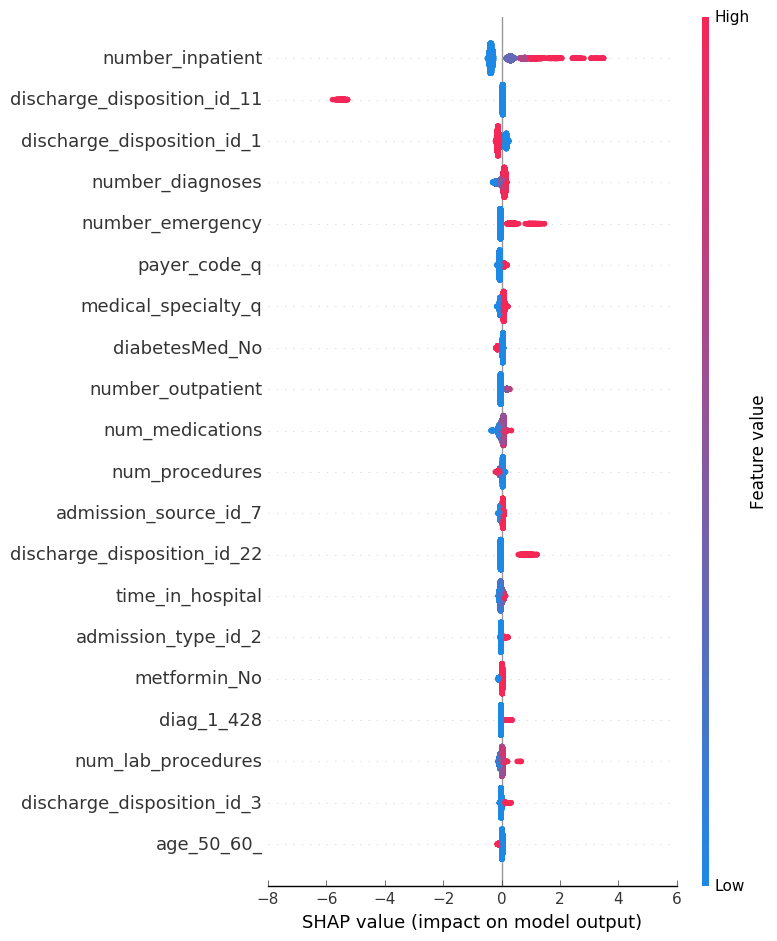

In [28]:
# last column of shap_values is global bias, not needed, caused errors sometimes
# must pass in columns in order xgboost expects for consistent results 
shap.summary_plot(shap_values[:, :-1], test[model.feature_names])

#### Function for calculating partial dependence and ICE

Partial dependence plots are used to view the global, average prediction behavior of a variable under the monotonic model. Partial dependence plots show the average prediction of the monotonic model as a function of specific values of an input variable of interest, indicating how the monotonic GBM predictions change based on the values of the input variable of interest, while taking nonlinearity into consideration and averaging out the effects of all other
input variables. Partial dependence plots enable increased transparency into the monotonic GBM's mechanisms and enable validation and debugging of the monotonic GBM by comparing a variable's average predictions across its domain to known standards and reasonable expectations. Partial dependence plots are described in greater detail in *The Elements of Statistical Learning*, section 10.13: https://web.stanford.edu/~hastie/ElemStatLearn/printings/ESLII_print12.pdf.

Individual conditional expectation (ICE) plots, a newer and less well-known adaptation of partial dependence plots, and can be used to create more localized explanations for a single observation of data using the same basic ideas as partial dependence plots. ICE is also a type of nonlinear sensitivity analysis in which the model predictions for a single observation are measured while a feature of interest is varied over its domain. ICE increases understanding and transparency by displaying the nonlinear behavior of the monotonic GBM. ICE also enhances trust, accountability, and fairness by enabling comparisons of nonlinear behavior to human domain knowledge and reasonable expectations. ICE, as a type of sensitivity analysis, can also engender trust when model behavior on simulated or extreme data points is acceptable. A detailed description of ICE is available in this arXiv preprint: https://arxiv.org/abs/1309.6392.

Because partial dependence and ICE are measured on the same scale, they can be displayed in the same line plot to compare the global, average prediction behavior for the entire model and the local prediction behavior for certain rows of data.

Because partial dependence and ICE will be calculated for several important variables in the GBM model, it's convenient to have a function doing so. It's probably best to analyze partial dependence and ICE for all variables in a model, but only the top five most important input variables will be investigated here. It's also a good idea to analyze partial dependence and ICE on the test data, or other holdout datasets, to see how the model will perform on new data. This simple function is designed to return partial dependence when it is called for an entire dataset and ICE when it is called for a single row. The `bins` argument will be used later to calculate ICE values at the same places in an input variable domain that partial dependence is calculated directly below. 

In [29]:
def par_dep(xs, frame, model, resolution=20, bins=None):
    
    """ Creates Pandas DataFrame containing partial dependence for a 
        single variable.
    
    Args:
        xs: Variable for which to calculate partial dependence.
        frame: Pandas DataFrame for which to calculate partial dependence.
        model: XGBoost model for which to calculate partial dependence.
        resolution: The number of points across the domain of xs for which 
                    to calculate partial dependence, default 20.
        bins: List of values at which to set xs, default 20 equally-spaced 
              points between column minimum and maximum.
    
    Returns:
        Pandas DataFrame containing partial dependence values.
        
    """
    
    # turn off pesky pandas copy warning
    pd.options.mode.chained_assignment = None
    
    # initialize empty pandas dataframe with correct column names
    par_dep_frame = pd.DataFrame(columns=[xs, 'partial_dependence'])
    
    # cache original column values 
    col_cache = frame.loc[:, xs].copy(deep=True)
  
    # determine values at which to calculate partial dependence
    if bins == None:
        min_ = frame[xs].min()
        max_ = frame[xs].max()
        by = (max_ - min_)/resolution
        bins = np.arange(min_, max_, by)
        
    # calculate partial dependence  
    # by setting column of interest to constant 
    # and scoring the altered data and taking the mean of the predictions
    for j in bins:
        frame.loc[:, xs] = j
        dframe = xgb.DMatrix(frame)
        par_dep_i = pd.DataFrame(model.predict(dframe))
        par_dep_j = par_dep_i.mean()[0]
        par_dep_frame = par_dep_frame.append({xs:j,
                                              'partial_dependence': par_dep_j}, 
                                              ignore_index=True)
        
    # return input frame to original cached state    
    frame.loc[:, xs] = col_cache

    return par_dep_frame

#### Calculate partial dependence for the most important input variables in the GBM

In [30]:
# calculating partial dependence took ~15 mins on my machine (8-core i7, 16 GB ram)
# this logic looks for stored partial dependence values as a file
# if it fails to find those files, the notebook runs the longish partial dependence calculations

# most important vars from global shapley 
important_vars = ['number_inpatient', 'discharge_disposition_id_11', 'discharge_disposition_id_1', 'number_diagnoses',\
                  'number_emergency']

# loop through important vars
for var in important_vars:

    # file name to look for
    fname = 'data/par_dep_' + var + '.csv'
    
    # check if partial dependence file exists
    # if yes
    if os.path.isfile(fname):
        
        code = 'par_dep_' + var + '= pd.read_csv(fname)'           # create code statements dynamically to avoid code repetition
        exec(code)                                                 # execute statement with exec(), i.e. load partial dependence
        print('Partial dependence for %s loaded from disk.' % var) # print confirmation
    
    # if no
    else: 
        
        
        code = 'par_dep_' + var + '= par_dep(var, test[X], model)' # create code statements dynamically to avoid code repetition
        exec(code)                                                 # execute statement with exec(), i.e. calculate partial dependence
        code = 'par_dep_' + var + '.to_csv(fname, index=False)'    # create code statements dynamically to avoid code repetition
        exec(code)                                                 # execute statement with exec(), i.e. save partial dependenence
        

Partial dependence for number_inpatient loaded from disk.
Partial dependence for discharge_disposition_id_11 loaded from disk.
Partial dependence for discharge_disposition_id_1 loaded from disk.
Partial dependence for number_diagnoses loaded from disk.
Partial dependence for number_emergency loaded from disk.


The next few cells perform basic data manipulation in order to plot partial dependence and ICE on the same scale in the same plot.

#### Add row ID column to test set for later joins

In [31]:
# need sequential column of integers from 0 to size of test set to find percentiles below
test['ID'] = np.arange(test.shape[0])

#### Bind XGBoost predictions to training data

In [32]:
xgb_preds = pd.DataFrame(model.predict(dtest)) # score test set to find percentiles of predictions below

#### Create new `Pandas` index

In [33]:
test.reset_index(inplace=True)                 # create new sequential index for join directly below
test.drop(['index'], inplace=True, axis=1)     # drop old index that came from when test set was sampled from entire data set

#### Convert from `Pandas` `DataFrame` to `H2OFrame`

In [34]:
decile_frame = pd.concat([test, xgb_preds], axis=1)         # join predictions to test set 
decile_frame = decile_frame.rename(columns={0: 'predict'})  # rename prediction column to 'predict'
decile_hframe = h2o.H2OFrame(decile_frame)                  # convert from pandas to h2oframe, needed to find percentiles below

Parse progress: |█████████████████████████████████████████████████████████| 100%


#### View joined data set

In [35]:
decile_frame.head() # show new row id and prediction columns (at far right)

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,A1Cresult_7,A1Cresult_8,A1Cresult_None,A1Cresult_Norm,acarbose_No,acarbose_Steady,insulin_Down,insulin_No,insulin_Steady,insulin_Up,diabetesMed_No,diabetesMed_Yes,medical_specialty_q,medical_specialty_Cardiology,medical_specialty_Emergency_Trauma,medical_specialty_Family_GeneralPractice,medical_specialty_InternalMedicine,medical_specialty_Nephrology,medical_specialty_Orthopedics,medical_specialty_Orthopedics_Reconstructive,medical_specialty_Other,medical_specialty_Psychiatry,medical_specialty_Surgery_General,glimepiride_Down,glimepiride_No,glimepiride_Steady,glimepiride_Up,miglitol_Down,miglitol_No,miglitol_Steady,discharge_disposition_id_1,discharge_disposition_id_2,discharge_disposition_id_3,discharge_disposition_id_4,discharge_disposition_id_5,discharge_disposition_id_6,discharge_disposition_id_7,discharge_disposition_id_11,discharge_disposition_id_13,discharge_disposition_id_14,discharge_disposition_id_18,discharge_disposition_id_22,discharge_disposition_id_23,discharge_disposition_id_25,discharge_disposition_id_Other,diag_2_250,diag_2_250_01,diag_2_250_02,diag_2_276,diag_2_285,diag_2_401,diag_2_403,diag_2_411,diag_2_414,diag_2_424,diag_2_425,diag_2_427,diag_2_428,diag_2_491,diag_2_496,diag_2_518,diag_2_599,diag_2_682,diag_2_707,diag_2_780,diag_2_Other,nateglinide_Down,nateglinide_No,nateglinide_Steady,nateglinide_Up,glipizide_Down,glipizide_No,glipizide_Steady,glipizide_Up,gender_Female,gender_Male,gender_Unknown_Invalid,glyburide_Down,glyburide_No,glyburide_Steady,glyburide_Up,admission_type_id_1,admission_type_id_2,admission_type_id_3,admission_type_id_4,admission_type_id_5,admission_type_id_6,admission_type_id_7,admission_type_id_8,rosiglitazone_Down,rosiglitazone_No,rosiglitazone_Steady,rosiglitazone_Up,metformin_Down,metformin_No,metformin_Steady,metformin_Up,diag_3_250,diag_3_250_01,diag_3_250_02,diag_3_250_6,diag_3_272,diag_3_276,diag_3_285,diag_3_401,diag_3_403,diag_3_414,diag_3_424,diag_3_427,diag_3_428,diag_3_496,diag_3_585,diag_3_599,diag_3_707,diag_3_780,diag_3_q,diag_3_Other,diag_3_V45,admission_source_id_1,admission_source_id_2,admission_source_id_3,admission_source_id_4,admission_source_id_5,admission_source_id_6,admission_source_id_7,admission_source_id_8,admission_source_id_9,admission_source_id_14,admission_source_id_17,admission_source_id_22,pioglitazone_Down,pioglitazone_No,pioglitazone_Steady,pioglitazone_Up,tolazamide_No,repaglinide_Down,repaglinide_No,repaglinide_Steady,repaglinide_Up,race_q,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,troglitazone_No,chlorpropamide_No,chlorpropamide_Steady,change_Ch,change_No,weight_q,weight_0_25_,weight_100_125_,weight_125_150_,weight_150_175_,weight_175_200_,weight_25_50_,weight_50_75_,weight_75_100_,payer_code_q,payer_code_BC,payer_code_CH,payer_code_CM,payer_code_CP,payer_code_DM,payer_code_HM,payer_code_MC,payer_code_MD,payer_code_MP,payer_code_OG,payer_code_OT,payer_code_PO,payer_code_SI,payer_code_SP,payer_code_UN,payer_code_WC,glyburide_metformin_No,glyburide_metformin_Steady,glipizide_metformin_No,max_glu_serum_200,max_glu_serum_300,max_glu_serum_None,max_glu_serum_Norm,diag_1_250_8,diag_1_276,diag_1_38,diag_1_410,diag_1_414,diag_1_427,diag_1_428,diag_1_434,diag_1_486,diag_1_491,diag_1_518,diag_1_584,diag_1_599,diag_1_682,diag_1_715,diag_1_780,diag_1_786,diag_1_820,diag_1_996,diag_1_Other,diag_1_V57,tolbutamide_No,tolbutamide_Steady,age_0_10_,age_10_20_,age_20_30_,age_30_40_,age_40_50_,age_50_60_,age_60_70_,age_70_80_,age_80_90_,age_90_100_,ID,predict
0,1,50,6,25,0,0,0,9,0,0,1,0,1,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,

#### Find percentiles of XGBoost predictions
Since we have not found any specific rows of interest yet, it's a justifiable starting point to examine rows locally at the minimum and maximum predictions and at each decile of predictions in between. The `get_percentile_dict()` function below returns the row identifier for the minimum and maximum predictions, and the deciles of predicted probability of `readmitted`.

In [36]:
# use previously defined utility function find row ids of prediction deciles, min., and max.
ds_ = DataMakerAndGetter()
percentile_dict = ds_.get_percentile_dict('predict', 'ID', decile_hframe)

#### Display min., max., and decile row IDs

In [37]:
percentile_dict # print row ids of prediction deciles, min., and max.

{0: 10943,
 10: 5576,
 20: 13429,
 30: 14570,
 40: 1798,
 50: 68,
 60: 7097,
 70: 7384,
 80: 1058,
 90: 3706,
 99: 3354}

#### Calculate ICE curve values
ICE values represent a model's prediction for a row of data while an input variable of interest is varied across its domain. The values of the input variable are chosen to match the values at which partial dependence was calculated earlier, and ICE is calculated for the top three most important variables and for rows at each percentile of the test dataset. 

In [38]:
# loop though important variables
for var in important_vars: 

    # retrieve bins from original partial dependence calculation
    # so ice is calculated at same values
    code = 'bins_%s = list(par_dep_%s["%s"])' % (var, var, var) # construct statement dynamically to avoid code repetition 
    exec(code)                                                  # execute statement to retrieve bins 

    # calculate ice curves across percentiles 
    # for each percentile in percentile_dict
    # create a new column in the partial depedence pandas dataframe 
    # representing the ice curve
    # for the specified variable and row at given percentile
    for i in sorted(percentile_dict.keys()):
    
        # new column name in partial dependence pandas dataframe to contain ice curve values 
        col_name = 'Percentile_' + str(i)
    
        # construct statement dynamically to avoid code repetition 
        code = """par_dep_%s[col_name] = par_dep('%s', 
                                                 test[test['ID'] == int(percentile_dict[i])][model.feature_names], 
                                                 model, 
                                                 bins=bins_%s)['partial_dependence']""" % (var, var, var)
        
        exec(code) # execute, i.e. calculate ice curve for specified row and variable 


#### Plot partial dependence and ICE
Overlaying partial dependence onto ICE in a plot is a convenient way to validate and understand both global and local monotonic behavior. Plots of partial dependence curves overlayed onto ICE curves for several percentiles of predictions for `readmitted` are used to validate monotonic behavior, describe the GBM model mechanisms, and to compare the most extreme GBM behavior with the average GBM behavior in the test data. Partial dependence and ICE plots are displayed for the five most important variables in the GBM: `number_inpatient`, `discharge_disposition_id_11`, `discharge_disposition_id_1`, `number_diagnoses`, and `numer_emergency`

In [39]:
def plot_par_dep_ICE(xs, par_dep_frame):

    
    """ Plots ICE overlayed onto partial dependence for a single variable.
    
    Args: 
        xs: Name of variable for which to plot ICE and partial dependence.
        par_dep_frame: Name of Pandas DataFrame containing ICE and partial
                       dependence values.
    
    """
    
    # initialize figure and axis
    fig, ax = plt.subplots()
    
    # plot ICE curves
    par_dep_frame.drop('partial_dependence', axis=1).plot(x=xs, 
                                                          colormap='gnuplot',
                                                          ax=ax)

    # overlay partial dependence, annotate plot
    par_dep_frame.plot(title='Partial Dependence and ICE for ' + str(xs),
                       x=xs, 
                       y='partial_dependence',
                       style='r-', 
                       linewidth=3, 
                       ax=ax)

    # add legend
    _ = plt.legend(bbox_to_anchor=(1.05, 0),
                   loc=3, 
                   borderaxespad=0.)


#### Partial dependence and ICE for `number_inpatient`

As `number_inpatient` increases the probability of readmission increases. The predictions follow this pattern on average and for the individuals at the minimum, maximum, and at each decile of predicted `readmitted`.

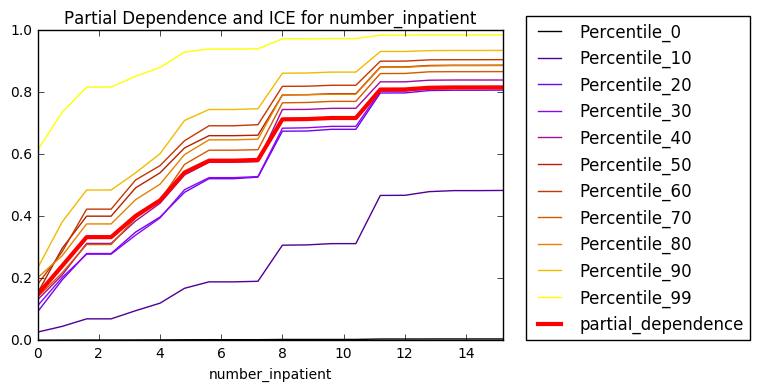

In [40]:
plot_par_dep_ICE('number_inpatient', par_dep_number_inpatient)

#### Partial dependence and ICE for `discharge_disposition_id_11`
When `discharge_disposition_id_11` = `1` (i.e. when a patient is discharged with code 11) the probability of readmission decreases. The predictions follow this pattern on average and for the individuals at the minimum, maximum, and at each decile of predicted `readmitted`.

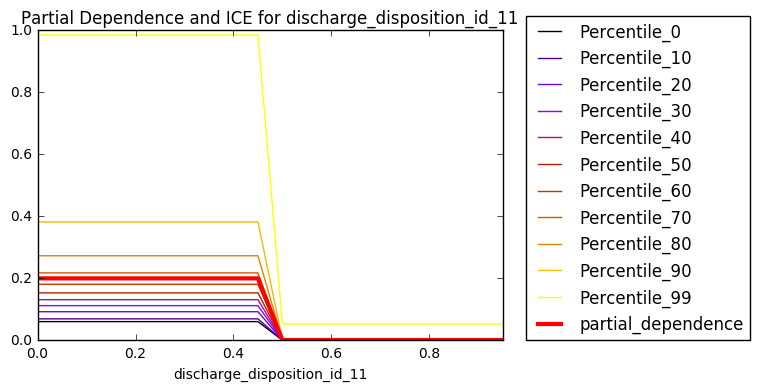

In [41]:
plot_par_dep_ICE('discharge_disposition_id_11', par_dep_discharge_disposition_id_11)

#### Partial dependence and ICE for `discharge_disposition_id_1`
When `discharge_disposition_id_1` = `1` (i.e. when a patient is discharged with code 1) the probability of readmission decreases. The predictions follow this pattern on average but not for the patients at the minimum and maximum probabilities for readmission. The value of `discharge_disposition_id_1` does not appear to affect these patients. When ICE diverges from partial dependence, this can indicate the model has learned an interaction that affects these individuals.

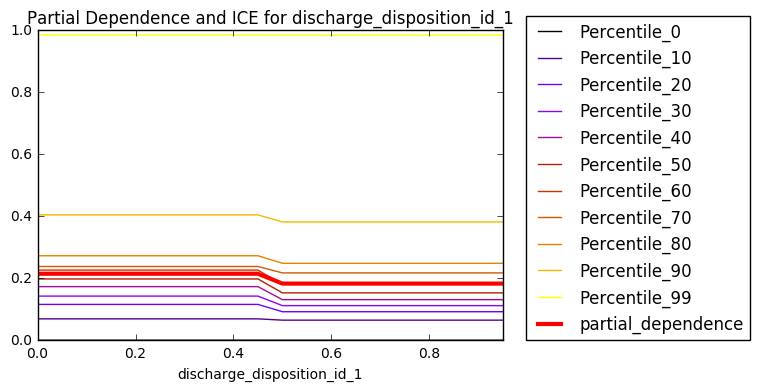

In [42]:
plot_par_dep_ICE('discharge_disposition_id_1', par_dep_discharge_disposition_id_1) # why is the bottom line flat?

#### Partial dependence and ICE for `number_diagnoses`
As number of diagnoses increases the probability of readmission increases. The predictions follow this pattern on average but not for the patients at the minimum and maximum probabilities for readmission. The value of `number_diagnoses` does not appear to affect these patients. When ICE diverges from partial dependence, this can indicate the model has learned an interaction that affects these individuals.

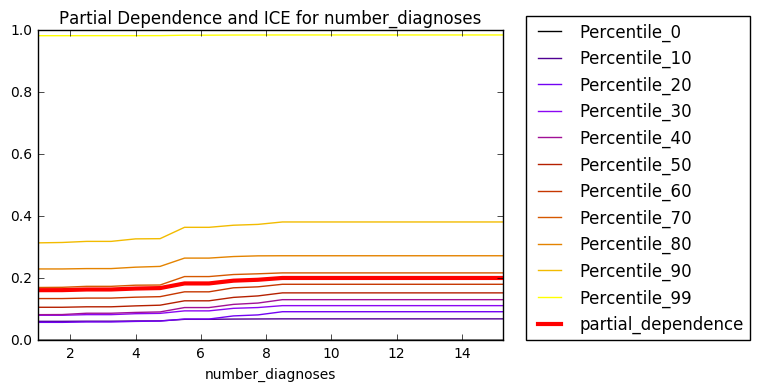

In [43]:
plot_par_dep_ICE('number_diagnoses', par_dep_number_diagnoses)

#### Partial dependence and ICE for `number_emergency`
As `number_emergency` increases the probability of readmission increases. The predictions follow this pattern on average and for the individuals at the minimum, maximum, and at each decile of predicted `readmitted`.

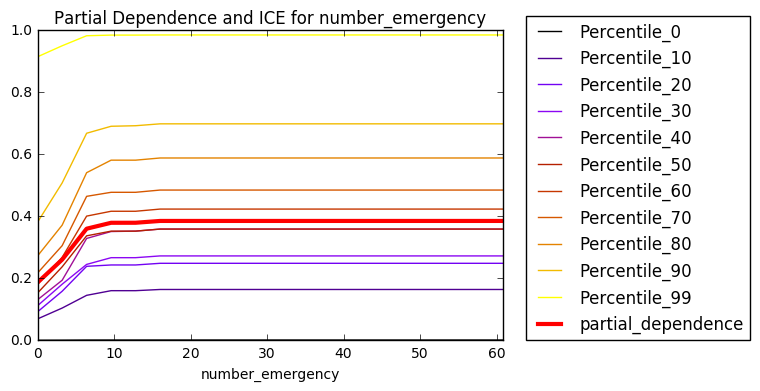

In [44]:
plot_par_dep_ICE('number_emergency', par_dep_number_emergency)

#### Train a surrogate decision tree

A surrogate model is a simple model that is used to explain a complex model. One of the original references for surrogate models is available here: https://papers.nips.cc/paper/1152-extracting-tree-structured-representations-of-trained-networks.pdf. In this example, a single decision tree will be trained on the original inputs and predictions of the monotonic classifier and the tree will be visualized using special functionality in `h2o` and `GraphViz`. The variable importance, interactions, and decision paths displayed in the directed graph of the trained decision tree surrogate model are then assumed to be indicative of the internal mechanisms of the more complex GBM model, creating an approximate, low-fidelity, overall flowchart for the GBM. There are few mathematical guarantees that the simple surrogate model is highly representative of the more complex GBM, but a recent preprint article has put forward ideas on strenghthening the theoretical relationship between surrogate models and more complex models: https://arxiv.org/pdf/1705.08504.pdf. Neither of these prescribed methods are followed here, instead the cross-validated error of the surrogate tree will be analyzed to assess accuracy and stability.

In [45]:
model_id = 'dt_surrogate_mojo' # gives MOJO artifact a recognizable name

# initialize single tree surrogate model
surrogate = H2ORandomForestEstimator(ntrees=1,          # use only one tree
                                     sample_rate=1,     # use all rows in that tree
                                     mtries=-2,         # use all columns in that tree
                                     max_depth=4,       # shallow trees are easier to understand
                                     nfolds=3,          # check stability
                                     seed=12345,        # random seed for reproducibility
                                     model_id=model_id) # gives MOJO artifact a recognizable name

# train single tree surrogate model
surrogate.train(x=X, y='predict', training_frame=decile_hframe)

# persist MOJO (compiled representation of trained model)
# from which to generate plot of surrogate
mojo_path = surrogate.download_mojo(path='.')
print('Generated MOJO path:\n', mojo_path)

drf Model Build progress: |███████████████████████████████████████████████| 100%
Generated MOJO path:
 /Users/phall/workspace/diabetes_use_case/dt_surrogate_mojo.zip


#### Examine cross-validated error metrics
Because one of the worst problems with single decision tree models is instability, cross-validated error metrics are examined across folds of the test data. The values here indicate the single tree is quite stable and also relatively accurate.

In [46]:
surrogate.cross_validation_metrics_summary() # h2o makes cv evalution metrics available

Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid
mae,0.0505445,0.0006971,0.0513149,0.0511658,0.0491530
mean_residual_deviance,0.0052504,0.0000256,0.0052780,0.0052739,0.0051993
mse,0.0052504,0.0000256,0.0052780,0.0052739,0.0051993
r2,0.7486192,0.0046901,0.7441233,0.7437376,0.7579967
residual_deviance,0.0052504,0.0000256,0.0052780,0.0052739,0.0051993
rmse,0.0724594,0.0001767,0.07265,0.0726218,0.0721064
rmsle,0.0570861,0.0002386,0.0571045,0.0574899,0.0566638


#### Create `GraphViz` dot file
`GraphViz` is an open source graph visualization tool. It is freely available from this url: http://www.graphviz.org/. To plot the trained decision tree surrogate model, a special `h2o` class, `PrintMojo`, is executed against the MOJO to create a `GraphViz` dot file representation of the tree.

In [47]:
# title for plot
title = 'Diabetes Decision Tree Surrogate'  

# locate h2o jar
hs = H2OLocalServer()
h2o_jar_path = hs._find_jar()
print('Discovered H2O jar path:\n', h2o_jar_path)

# construct command line call to generate graphviz version of 
# surrogate tree see for more information: 
# http://docs.h2o.ai/h2o/latest-stable/h2o-genmodel/javadoc/index.html
gv_file_name = model_id + '.gv'
gv_args = str('-cp ' + h2o_jar_path +
              ' hex.genmodel.tools.PrintMojo --tree 0 -i '
              + mojo_path + ' -o').split()
gv_args.insert(0, 'java')
gv_args.append(gv_file_name)
if title is not None:
    gv_args = gv_args + ['--title', title]
    
# call 
print()
print('Calling external process ...')
print(' '.join(gv_args))
_ = subprocess.call(gv_args)

Discovered H2O jar path:
 /Users/phall/anaconda/lib/python3.5/site-packages/h2o/backend/bin/h2o.jar

Calling external process ...
java -cp /Users/phall/anaconda/lib/python3.5/site-packages/h2o/backend/bin/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i /Users/phall/workspace/diabetes_use_case/dt_surrogate_mojo.zip -o dt_surrogate_mojo.gv --title Diabetes Decision Tree Surrogate


#### Create PNG from GraphViz dot file and display
Then a `GraphViz` command line tool is used to create a static PNG image from the dot file ... 

In [48]:
# construct call to generate PNG from 
# graphviz representation of the tree
png_file_name = model_id + '.png'
png_args = str('dot -Tpng ' + gv_file_name + ' -o ' + png_file_name)
png_args = png_args.split()

# call
print('Calling external process ...')
print(' '.join(png_args))
_ = subprocess.call(png_args)

Calling external process ...
dot -Tpng dt_surrogate_mojo.gv -o dt_surrogate_mojo.png


#### Display decision tree surrogate as model flow chart
... and the image is displayed in the notebook.

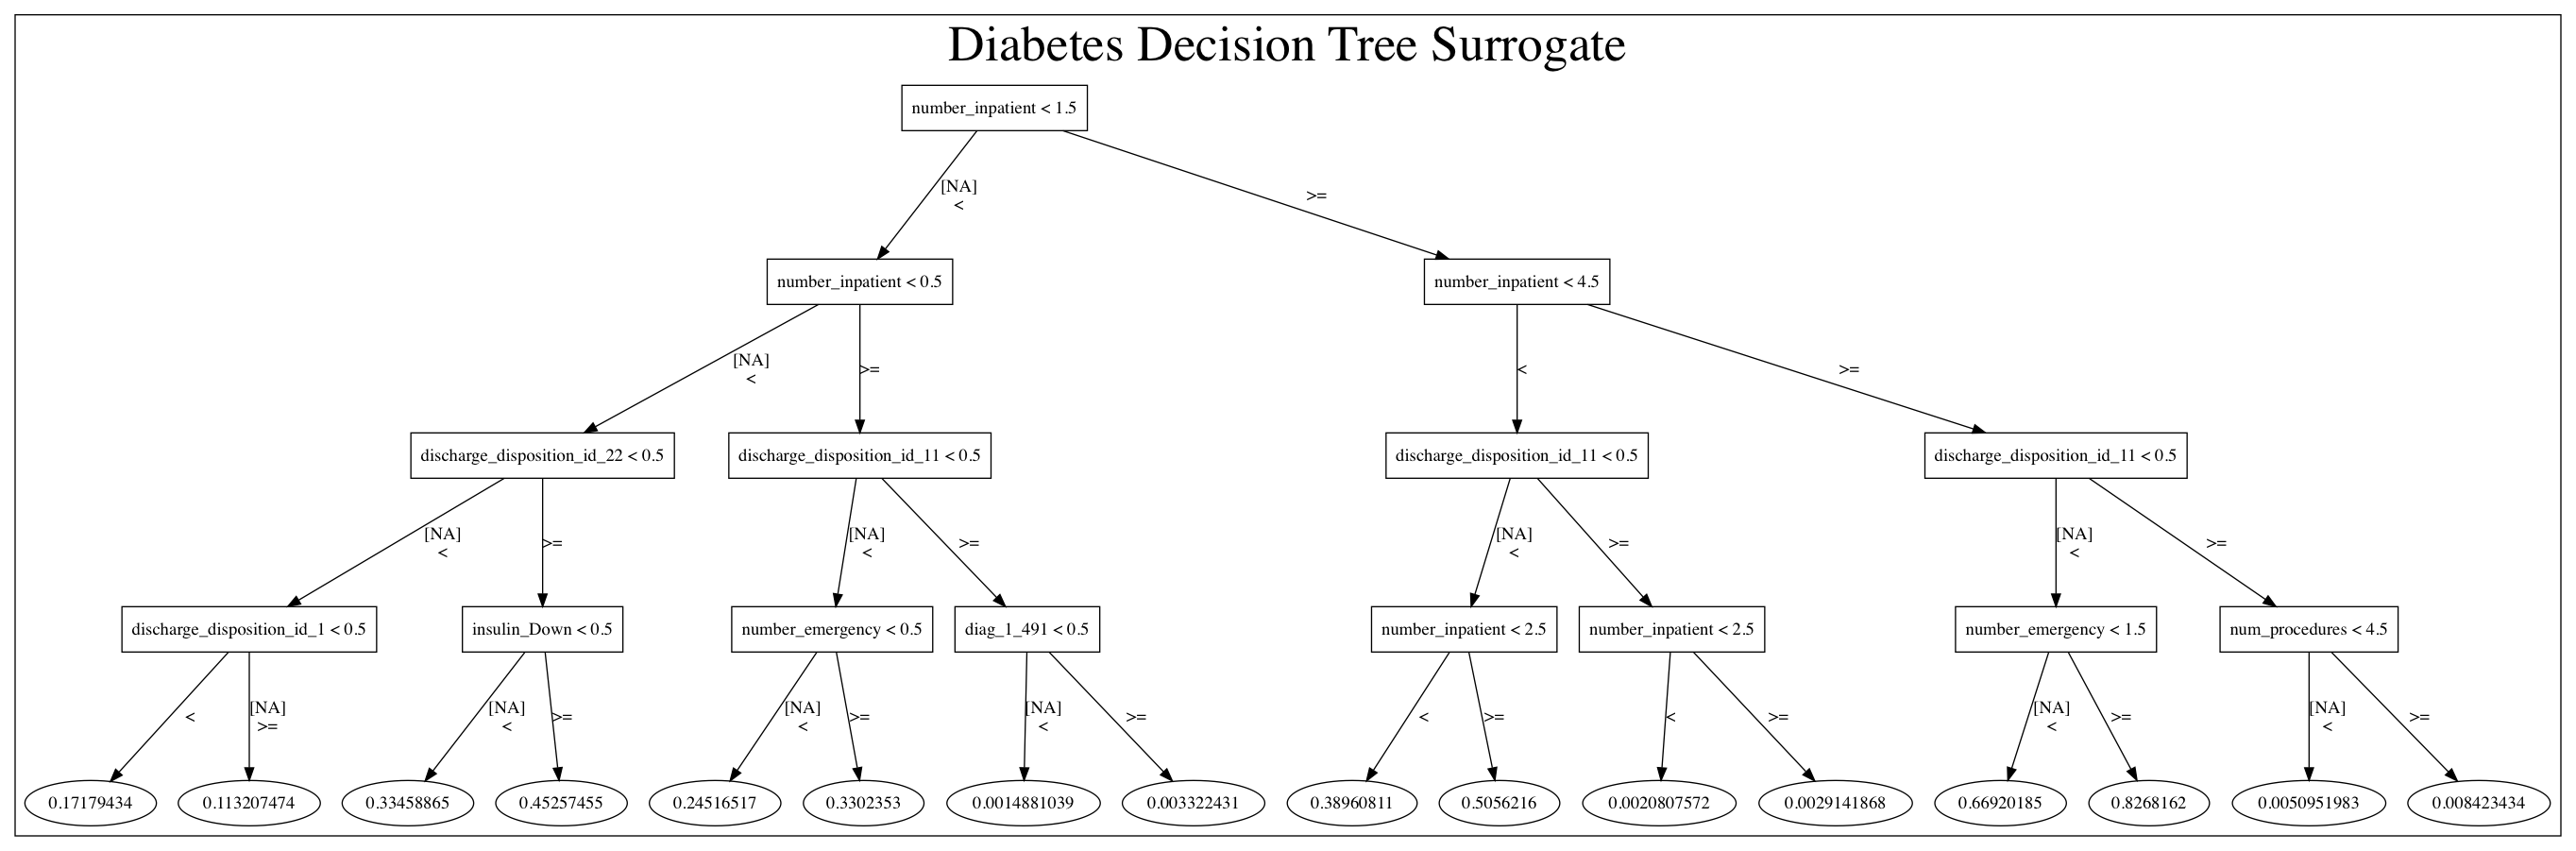

In [49]:
# display in-notebook
display(Image((png_file_name)))

The displayed tree is comparable with the global Shapley variable importance. A simple heuristic rule for variable importance in a decision tree relates to the depth and frequency at which a variable is split on in a tree: variables used higher in the tree and more frequently in the tree are more important. Most of the variables pictured in this tree also appear as highly important in the Shapley variable importance plot. In both cases, `number_inpatient` is appearing as crucially important. 

The surrogate decision tree enables practicioners to understand and confirm not only what input variables are important, but also how their values contribute to model decisions. For instance, to fall into the lowest probability of readmission leaf node in the surrogate decision tree a patient must have only one inpatient procedures, be discharged with code 11, and not have a primary diagnosis ICD 9 code of 491, which corresponds to chronic bronchitis. To fall into the highest readmission probability leaf node a patient will have 5 or more inpatient procedures, not be discharged with code 11, and have two or more emergency procedures.

It is imperative to compare these results to domain knowledge and reasonable expectations. In this case, the explanatory methods applied thus far tell a basically consisent and reasonable story about the model's behavior. If this was not so, steps should be taken to either reconcile or remove inconsistencies and unreasonable prediction behavior.

# Local explanations (variable importance) at several percentiles of model predictions

***

Now that the monotonic behavior of the GBM has been verified and compared against a few reasonable expectations, Shapley explanations will be used to calculate the local variable importance for any one prediction. Very crucially Shapley values *always* sum to the actual prediction of the `XGBoost` model. When used for decision tree models, Shapley values are likely the most accurate known local variable importance method available today. (I.e. they are a high-fidelity approach in this context.)

The numeric Shapley values in each column of the `shap_values` array are an estimate of how much each variable contributed to each prediction. Shapley contributions can indicate how a variable and its values were weighted in *any* given decision by the model. These values are crucially important for machine learning interpretability and are related to "local feature importance", "reason codes", or "turn-down codes." The latter phrases are borrowed from credit scoring. Credit lenders in the U.S. must provide reasons for automatically rejecting a credit application. Reason codes can be easily extracted from Shapley local variable contribution values by ranking the variables that played the largest role in any given decision.

Below predictions at the 10th, 50th, and 90th deciles for predicted `readmitted` are analyzed using local Shapley values. Using domain knowledge or other techniques like residual analysis could help practicioners choose potentially more appropriate rows to analyze.

#### Utility function that displays the Shapley results at the choosen decile

In [50]:
def shapley(row):
    
    """ Summarize local Shapley information. 
    
    :param row: The row to explain from numpy array of Shapley values.
    
    """
    
    # select shapley values for row
    # reshape into column vector
    # convert to pandas dataframe for easy plotting
    s_df = pd.DataFrame(shap_values[row.index[0], :][:-1].reshape(shap_values.shape[1]-1, 1), 
                        columns=['Approximate Local Contributions'],
                        index=model.feature_names) # must use feature_names for consistent results

    # sort dataframe by shapley values and print values
    s_df = s_df.sort_values(by='Approximate Local Contributions')
    print(s_df, '\n')

    # plot top positive contributors for this row
    _= s_df.iloc[-5:,:].plot(kind='bar', title='Approximate Local Contributions', legend=False)
    
    # manually calculate sum of shapley values for row
    print('Shapley sum: ', s_df['Approximate Local Contributions'].sum() + shap_values[row.index[0], -1])
    
    # manually calculate actual model prediction before application of logit link function
    p = row['predict'].values[0]
    print('Model prediction: ', np.log(p/(1 - p))) # inverse logit

####  10th decile of model predictions

In [51]:
decile = 10
row = decile_frame[decile_frame['ID'] == percentile_dict[decile]]

#### Shapley values

                                          Approximate Local Contributions
discharge_disposition_id_13                                     -2.003291
diag_3_Other                                                    -0.090288
payer_code_q                                                    -0.086295
insulin_Steady                                                  -0.047529
number_emergency                                                -0.038741
number_outpatient                                               -0.032679
admission_type_id_2                                             -0.029113
num_medications                                                 -0.027166
discharge_disposition_id_22                                     -0.027099
num_lab_procedures                                              -0.026944
diag_2_428                                                      -0.024639
diag_1_428                                                      -0.019823
time_in_hospital                      

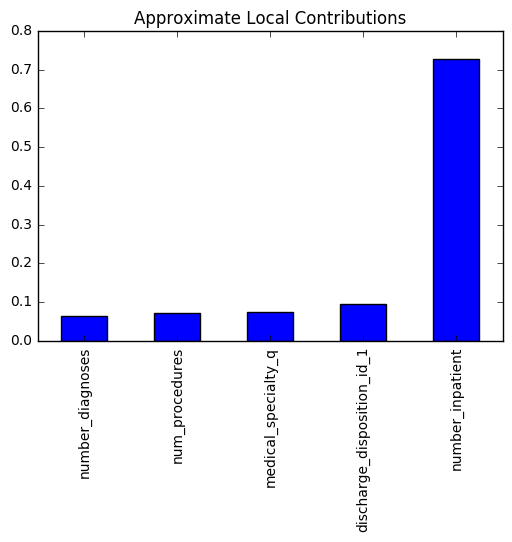

In [52]:
shapley(row)

#### Display values for patient

In [53]:
row

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,A1Cresult_7,A1Cresult_8,A1Cresult_None,A1Cresult_Norm,acarbose_No,acarbose_Steady,insulin_Down,insulin_No,insulin_Steady,insulin_Up,diabetesMed_No,diabetesMed_Yes,medical_specialty_q,medical_specialty_Cardiology,medical_specialty_Emergency_Trauma,medical_specialty_Family_GeneralPractice,medical_specialty_InternalMedicine,medical_specialty_Nephrology,medical_specialty_Orthopedics,medical_specialty_Orthopedics_Reconstructive,medical_specialty_Other,medical_specialty_Psychiatry,medical_specialty_Surgery_General,glimepiride_Down,glimepiride_No,glimepiride_Steady,glimepiride_Up,miglitol_Down,miglitol_No,miglitol_Steady,discharge_disposition_id_1,discharge_disposition_id_2,discharge_disposition_id_3,discharge_disposition_id_4,discharge_disposition_id_5,discharge_disposition_id_6,discharge_disposition_id_7,discharge_disposition_id_11,discharge_disposition_id_13,discharge_disposition_id_14,discharge_disposition_id_18,discharge_disposition_id_22,discharge_disposition_id_23,discharge_disposition_id_25,discharge_disposition_id_Other,diag_2_250,diag_2_250_01,diag_2_250_02,diag_2_276,diag_2_285,diag_2_401,diag_2_403,diag_2_411,diag_2_414,diag_2_424,diag_2_425,diag_2_427,diag_2_428,diag_2_491,diag_2_496,diag_2_518,diag_2_599,diag_2_682,diag_2_707,diag_2_780,diag_2_Other,nateglinide_Down,nateglinide_No,nateglinide_Steady,nateglinide_Up,glipizide_Down,glipizide_No,glipizide_Steady,glipizide_Up,gender_Female,gender_Male,gender_Unknown_Invalid,glyburide_Down,glyburide_No,glyburide_Steady,glyburide_Up,admission_type_id_1,admission_type_id_2,admission_type_id_3,admission_type_id_4,admission_type_id_5,admission_type_id_6,admission_type_id_7,admission_type_id_8,rosiglitazone_Down,rosiglitazone_No,rosiglitazone_Steady,rosiglitazone_Up,metformin_Down,metformin_No,metformin_Steady,metformin_Up,diag_3_250,diag_3_250_01,diag_3_250_02,diag_3_250_6,diag_3_272,diag_3_276,diag_3_285,diag_3_401,diag_3_403,diag_3_414,diag_3_424,diag_3_427,diag_3_428,diag_3_496,diag_3_585,diag_3_599,diag_3_707,diag_3_780,diag_3_q,diag_3_Other,diag_3_V45,admission_source_id_1,admission_source_id_2,admission_source_id_3,admission_source_id_4,admission_source_id_5,admission_source_id_6,admission_source_id_7,admission_source_id_8,admission_source_id_9,admission_source_id_14,admission_source_id_17,admission_source_id_22,pioglitazone_Down,pioglitazone_No,pioglitazone_Steady,pioglitazone_Up,tolazamide_No,repaglinide_Down,repaglinide_No,repaglinide_Steady,repaglinide_Up,race_q,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,troglitazone_No,chlorpropamide_No,chlorpropamide_Steady,change_Ch,change_No,weight_q,weight_0_25_,weight_100_125_,weight_125_150_,weight_150_175_,weight_175_200_,weight_25_50_,weight_50_75_,weight_75_100_,payer_code_q,payer_code_BC,payer_code_CH,payer_code_CM,payer_code_CP,payer_code_DM,payer_code_HM,payer_code_MC,payer_code_MD,payer_code_MP,payer_code_OG,payer_code_OT,payer_code_PO,payer_code_SI,payer_code_SP,payer_code_UN,payer_code_WC,glyburide_metformin_No,glyburide_metformin_Steady,glipizide_metformin_No,max_glu_serum_200,max_glu_serum_300,max_glu_serum_None,max_glu_serum_Norm,diag_1_250_8,diag_1_276,diag_1_38,diag_1_410,diag_1_414,diag_1_427,diag_1_428,diag_1_434,diag_1_486,diag_1_491,diag_1_518,diag_1_584,diag_1_599,diag_1_682,diag_1_715,diag_1_780,diag_1_786,diag_1_820,diag_1_996,diag_1_Other,diag_1_V57,tolbutamide_No,tolbutamide_Steady,age_0_10_,age_10_20_,age_20_30_,age_30_40_,age_40_50_,age_50_60_,age_60_70_,age_70_80_,age_80_90_,age_90_100_,ID,predict
5576,3,31,0,12,0,0,2,9,0,0,1,0,1,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0

In [54]:
print('Predicted readmission probability:', row['predict'].values[0])
print('Actual readmission value:', 
      pd.read_csv('data/diabetes_test.csv').loc[row.index[0], 'readmitted'])

Predicted readmission probability: 0.0693604
Actual readmission value: <30


This patient is ranked at a relatively low probability of readmission, but they were readmitted. In this case the model was wrong. The Shapley values are useful because they show exactly which variables were weighed heavily for this prediction, and may provide some insight into why the model was wrong for this patient. The model is weighing the patient's `discharge_disposition_id` value of `13` relatively strongly in it's decision to predict the patient will not be readmitted. The numeric value of the contribution for `discharge_disposition_id` is relatively high, but domain knowledge should be applied to determine if this is a valid criterion for a low probability prediction.

####  Median of predictions

In [55]:
decile = 50
row = decile_frame[decile_frame['ID'] == percentile_dict[decile]]

#### Shapley values

                                              Approximate Local Contributions
number_inpatient                                                    -0.395059
discharge_disposition_id_1                                          -0.130663
age_50_60_                                                          -0.108001
payer_code_q                                                        -0.065117
number_emergency                                                    -0.042847
time_in_hospital                                                    -0.032680
number_outpatient                                                   -0.030981
discharge_disposition_id_22                                         -0.029631
admission_type_id_2                                                 -0.023767
diag_1_428                                                          -0.020213
discharge_disposition_id_3                                          -0.016980
age_70_80_                                                      

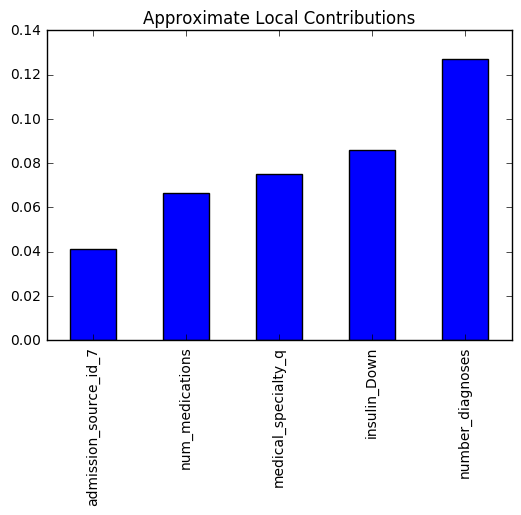

In [56]:
shapley(row)

#### Display values for patient

In [57]:
row

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,A1Cresult_7,A1Cresult_8,A1Cresult_None,A1Cresult_Norm,acarbose_No,acarbose_Steady,insulin_Down,insulin_No,insulin_Steady,insulin_Up,diabetesMed_No,diabetesMed_Yes,medical_specialty_q,medical_specialty_Cardiology,medical_specialty_Emergency_Trauma,medical_specialty_Family_GeneralPractice,medical_specialty_InternalMedicine,medical_specialty_Nephrology,medical_specialty_Orthopedics,medical_specialty_Orthopedics_Reconstructive,medical_specialty_Other,medical_specialty_Psychiatry,medical_specialty_Surgery_General,glimepiride_Down,glimepiride_No,glimepiride_Steady,glimepiride_Up,miglitol_Down,miglitol_No,miglitol_Steady,discharge_disposition_id_1,discharge_disposition_id_2,discharge_disposition_id_3,discharge_disposition_id_4,discharge_disposition_id_5,discharge_disposition_id_6,discharge_disposition_id_7,discharge_disposition_id_11,discharge_disposition_id_13,discharge_disposition_id_14,discharge_disposition_id_18,discharge_disposition_id_22,discharge_disposition_id_23,discharge_disposition_id_25,discharge_disposition_id_Other,diag_2_250,diag_2_250_01,diag_2_250_02,diag_2_276,diag_2_285,diag_2_401,diag_2_403,diag_2_411,diag_2_414,diag_2_424,diag_2_425,diag_2_427,diag_2_428,diag_2_491,diag_2_496,diag_2_518,diag_2_599,diag_2_682,diag_2_707,diag_2_780,diag_2_Other,nateglinide_Down,nateglinide_No,nateglinide_Steady,nateglinide_Up,glipizide_Down,glipizide_No,glipizide_Steady,glipizide_Up,gender_Female,gender_Male,gender_Unknown_Invalid,glyburide_Down,glyburide_No,glyburide_Steady,glyburide_Up,admission_type_id_1,admission_type_id_2,admission_type_id_3,admission_type_id_4,admission_type_id_5,admission_type_id_6,admission_type_id_7,admission_type_id_8,rosiglitazone_Down,rosiglitazone_No,rosiglitazone_Steady,rosiglitazone_Up,metformin_Down,metformin_No,metformin_Steady,metformin_Up,diag_3_250,diag_3_250_01,diag_3_250_02,diag_3_250_6,diag_3_272,diag_3_276,diag_3_285,diag_3_401,diag_3_403,diag_3_414,diag_3_424,diag_3_427,diag_3_428,diag_3_496,diag_3_585,diag_3_599,diag_3_707,diag_3_780,diag_3_q,diag_3_Other,diag_3_V45,admission_source_id_1,admission_source_id_2,admission_source_id_3,admission_source_id_4,admission_source_id_5,admission_source_id_6,admission_source_id_7,admission_source_id_8,admission_source_id_9,admission_source_id_14,admission_source_id_17,admission_source_id_22,pioglitazone_Down,pioglitazone_No,pioglitazone_Steady,pioglitazone_Up,tolazamide_No,repaglinide_Down,repaglinide_No,repaglinide_Steady,repaglinide_Up,race_q,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,troglitazone_No,chlorpropamide_No,chlorpropamide_Steady,change_Ch,change_No,weight_q,weight_0_25_,weight_100_125_,weight_125_150_,weight_150_175_,weight_175_200_,weight_25_50_,weight_50_75_,weight_75_100_,payer_code_q,payer_code_BC,payer_code_CH,payer_code_CM,payer_code_CP,payer_code_DM,payer_code_HM,payer_code_MC,payer_code_MD,payer_code_MP,payer_code_OG,payer_code_OT,payer_code_PO,payer_code_SI,payer_code_SP,payer_code_UN,payer_code_WC,glyburide_metformin_No,glyburide_metformin_Steady,glipizide_metformin_No,max_glu_serum_200,max_glu_serum_300,max_glu_serum_None,max_glu_serum_Norm,diag_1_250_8,diag_1_276,diag_1_38,diag_1_410,diag_1_414,diag_1_427,diag_1_428,diag_1_434,diag_1_486,diag_1_491,diag_1_518,diag_1_584,diag_1_599,diag_1_682,diag_1_715,diag_1_780,diag_1_786,diag_1_820,diag_1_996,diag_1_Other,diag_1_V57,tolbutamide_No,tolbutamide_Steady,age_0_10_,age_10_20_,age_20_30_,age_30_40_,age_40_50_,age_50_60_,age_60_70_,age_70_80_,age_80_90_,age_90_100_,ID,predict
68,3,60,1,19,0,0,0,9,0,0,1,0,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [58]:
print('Predicted readmission probability:', row['predict'].values[0])
print('Actual readmission value:', 
      pd.read_csv('data/diabetes_test.csv').loc[row.index[0], 'readmitted'])

Predicted readmission probability: 0.153186
Actual readmission value: NO


In this case the model predicted the patient has a median probability for readmission and they were not readmitted. The lack of inpatient procedures, `discharge_disposition_id` value of `1`, and their age being between 50-60 all contributed negatively to the predicted probability. Their relatively high number of diagnoses, 9, their insulin dosage being decreased, and their provider's `medical_specialty` being unknown (`?`/`q`) all contributed positively to the predicted probability of `readmitted`.

####  90th decile of model predictions

In [59]:
decile = 90
row = decile_frame[decile_frame['ID'] == percentile_dict[decile]]

#### Shapley values

                                              Approximate Local Contributions
discharge_disposition_id_1                                          -0.082025
medical_specialty_q                                                 -0.059474
number_emergency                                                    -0.040275
number_outpatient                                                   -0.032355
discharge_disposition_id_22                                         -0.020458
discharge_disposition_id_3                                          -0.016557
medical_specialty_Surgery_General                                   -0.015629
discharge_disposition_id_2                                          -0.012397
insulin_Down                                                        -0.012286
discharge_disposition_id_5                                          -0.012285
admission_type_id_6                                                 -0.011649
medical_specialty_Family_GeneralPractice                        

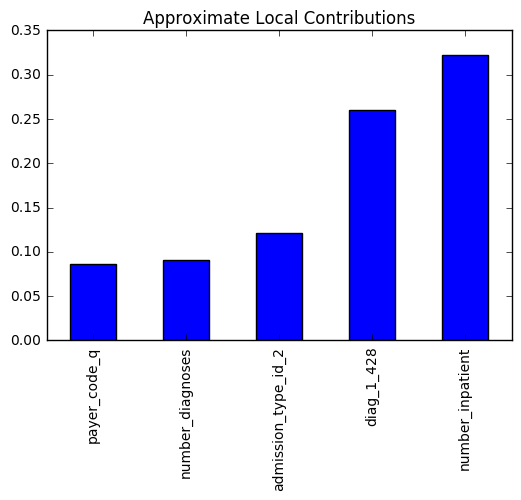

In [60]:
shapley(row)

#### Display values for patient

In [61]:
row 

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,A1Cresult_7,A1Cresult_8,A1Cresult_None,A1Cresult_Norm,acarbose_No,acarbose_Steady,insulin_Down,insulin_No,insulin_Steady,insulin_Up,diabetesMed_No,diabetesMed_Yes,medical_specialty_q,medical_specialty_Cardiology,medical_specialty_Emergency_Trauma,medical_specialty_Family_GeneralPractice,medical_specialty_InternalMedicine,medical_specialty_Nephrology,medical_specialty_Orthopedics,medical_specialty_Orthopedics_Reconstructive,medical_specialty_Other,medical_specialty_Psychiatry,medical_specialty_Surgery_General,glimepiride_Down,glimepiride_No,glimepiride_Steady,glimepiride_Up,miglitol_Down,miglitol_No,miglitol_Steady,discharge_disposition_id_1,discharge_disposition_id_2,discharge_disposition_id_3,discharge_disposition_id_4,discharge_disposition_id_5,discharge_disposition_id_6,discharge_disposition_id_7,discharge_disposition_id_11,discharge_disposition_id_13,discharge_disposition_id_14,discharge_disposition_id_18,discharge_disposition_id_22,discharge_disposition_id_23,discharge_disposition_id_25,discharge_disposition_id_Other,diag_2_250,diag_2_250_01,diag_2_250_02,diag_2_276,diag_2_285,diag_2_401,diag_2_403,diag_2_411,diag_2_414,diag_2_424,diag_2_425,diag_2_427,diag_2_428,diag_2_491,diag_2_496,diag_2_518,diag_2_599,diag_2_682,diag_2_707,diag_2_780,diag_2_Other,nateglinide_Down,nateglinide_No,nateglinide_Steady,nateglinide_Up,glipizide_Down,glipizide_No,glipizide_Steady,glipizide_Up,gender_Female,gender_Male,gender_Unknown_Invalid,glyburide_Down,glyburide_No,glyburide_Steady,glyburide_Up,admission_type_id_1,admission_type_id_2,admission_type_id_3,admission_type_id_4,admission_type_id_5,admission_type_id_6,admission_type_id_7,admission_type_id_8,rosiglitazone_Down,rosiglitazone_No,rosiglitazone_Steady,rosiglitazone_Up,metformin_Down,metformin_No,metformin_Steady,metformin_Up,diag_3_250,diag_3_250_01,diag_3_250_02,diag_3_250_6,diag_3_272,diag_3_276,diag_3_285,diag_3_401,diag_3_403,diag_3_414,diag_3_424,diag_3_427,diag_3_428,diag_3_496,diag_3_585,diag_3_599,diag_3_707,diag_3_780,diag_3_q,diag_3_Other,diag_3_V45,admission_source_id_1,admission_source_id_2,admission_source_id_3,admission_source_id_4,admission_source_id_5,admission_source_id_6,admission_source_id_7,admission_source_id_8,admission_source_id_9,admission_source_id_14,admission_source_id_17,admission_source_id_22,pioglitazone_Down,pioglitazone_No,pioglitazone_Steady,pioglitazone_Up,tolazamide_No,repaglinide_Down,repaglinide_No,repaglinide_Steady,repaglinide_Up,race_q,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,troglitazone_No,chlorpropamide_No,chlorpropamide_Steady,change_Ch,change_No,weight_q,weight_0_25_,weight_100_125_,weight_125_150_,weight_150_175_,weight_175_200_,weight_25_50_,weight_50_75_,weight_75_100_,payer_code_q,payer_code_BC,payer_code_CH,payer_code_CM,payer_code_CP,payer_code_DM,payer_code_HM,payer_code_MC,payer_code_MD,payer_code_MP,payer_code_OG,payer_code_OT,payer_code_PO,payer_code_SI,payer_code_SP,payer_code_UN,payer_code_WC,glyburide_metformin_No,glyburide_metformin_Steady,glipizide_metformin_No,max_glu_serum_200,max_glu_serum_300,max_glu_serum_None,max_glu_serum_Norm,diag_1_250_8,diag_1_276,diag_1_38,diag_1_410,diag_1_414,diag_1_427,diag_1_428,diag_1_434,diag_1_486,diag_1_491,diag_1_518,diag_1_584,diag_1_599,diag_1_682,diag_1_715,diag_1_780,diag_1_786,diag_1_820,diag_1_996,diag_1_Other,diag_1_V57,tolbutamide_No,tolbutamide_Steady,age_0_10_,age_10_20_,age_20_30_,age_30_40_,age_40_50_,age_50_60_,age_60_70_,age_70_80_,age_80_90_,age_90_100_,ID,predict
3706,4,41,0,15,0,0,1,9,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0

In [62]:
print('Predicted readmission probability:', row['predict'].values[0])
print('Actual readmission value:', 
      pd.read_csv('data/diabetes_test.csv').loc[row.index[0], 'readmitted'])

Predicted readmission probability: 0.38192
Actual readmission value: <30


In this case the model predicted the patient has a relatively high probability of being readmitted and they were readmitted. The patient's `discharge_disposition_id` value of `1`, their provider's medical specialty not being unknown (`?`/`q`), and their lack of emergency procedures all contributed negatively to the predicted probability. Their number of inpatient procedures, 1, their being admitted as a referral from another clinic, and primary diagnosis ICD9 code being 428, which corresponds to heart failure, all contributed positively to the predicted probability of `readmitted`.

# Brief conclusion

This notebook contains open source and freely available code examples for training an interpretable monotonic classifier and applying a number of interpretability and explanatory methods to this classifier to explain both the global and local modeling results. It is left to practicioners and domain experts to determine whether these techiques truly surpass more established methods by any number of criteria, e.g. ability to handle heterogeneous data, accuracy, interpretability, etc. The only explicit argument made here is: when people's lives are being affected by mathematical models, it does seem prudent to investigate and evaluate many possible modeling and analysis techniques. 

#### Shutdown `H2O` server after analysis is finished

In [63]:
# shutdown h2o server to save resources 
# careful, this can erase your work
h2o.cluster().shutdown()

H2O session _sid_8111 closed.
